In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm
import healpy as hp
import numpy.ma as ma
from healpy.sphtfunc import Alm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. Load some example data 
_Gaia_ QSOs.

In [2]:
# Load quasars into a DataFrame
quasars_pd = pd.read_csv("data/quasars_phot.csv")

In [3]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values

In [4]:
pm_ra_cosdec = quasars_pd['pmra'].values*np.cos(quasars_pd['dec'].values*np.pi/180.)
pm_dec = quasars_pd['pmdec'].values
radial_velocity = quasars_pd['radial_velocity'].values

In [5]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
             dec=dec*u.deg, 
             pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, 
             pm_dec=pm_dec*u.mas/u.yr,
             radial_velocity=radial_velocity*u.km/u.s,
             frame='icrs')

In [6]:
quasars_gal = quasars_icrs.transform_to('galactic')

In [7]:
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

In [8]:
nside = 32
qpix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))
# qpix = hp.ang2pix(nside,np.deg2rad(l_gal),np.deg2rad(b_gal))

quasars_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))
rv_map = np.zeros(hp.nside2npix(nside))

In [9]:
for idx, ipix in enumerate(tqdm_notebook((qpix))):
    quasars_map[ipix] += 1

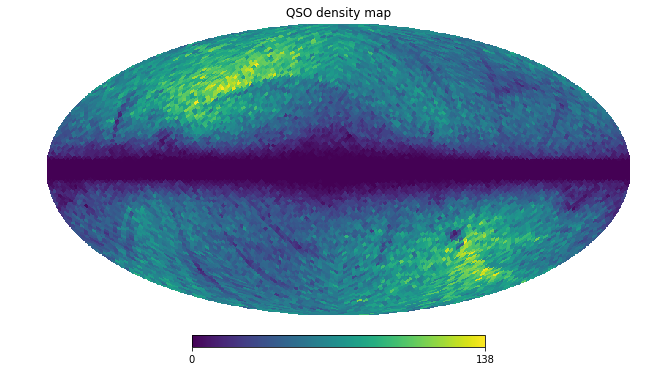

In [10]:
hp.mollview(quasars_map, title='QSO density map')

# 2. Anafast estimates
Some baselines.

In [11]:
lmax = 3*nside - 1
alm_qso_anafast = hp.map2alm(quasars_map, lmax=lmax)

In [12]:
l = 3
m = 2
alm_qso_anafast[Alm.getidx(lmax, l, m)]

(-0.47447167415193153+1.853227716659314j)

# 3. Brute force estimate

Estimate as integral $\rightarrow$ sum over pixels.

In [13]:
from mpmath import spherharm
from scipy.special import sph_harm

In [14]:
def Ylm(l, m, theta, phi): 
    """
    Redefine spherical harmonics from scipy.special
    to match physics convention.
    
    Parameters
    ----------
    l : int, array_like
        Degree of the harmonic (int); ``l >= 0``.
    m : int, array_like
        Order of the harmonic (int); ``|m| <= l``.
    theta : array_like
        Polar (colatitudinal) coordinate; must be in ``[0, pi]``.
    phi : array_like
        Azimuthal (longitudinal) coordinate; must be in ``[0, 2*pi]``.
    
    Returns
    -------
    Ylm : complex float
       The harmonic Ylm sampled at ``theta`` and ``phi``.
    """
    if np.abs(m) > l:
        Ylm = 0
    else:
        Ylm = sph_harm(m, l, phi, theta) # Perform redefinition
#         Ylm = spherharm(l, m, theta, phi)
    return Ylm

def map2alm(the_map, l, m):
    nside = hp.npix2nside(len(the_map))
    alm = 0
    domega = hp.nside2pixarea(nside)
    for ipix in range(len(the_map)):
        theta, phi = hp.pix2ang(nside, ipix)
        alm += the_map[ipix]*np.conjugate(Ylm(l, m, theta, phi))*domega
    return alm


In [15]:
map2alm(quasars_map, l, m)

(-0.4745116673422355+1.8537158311180102j)

Matches the above, so far so good...

# 4. "Whole sphere data" from Dahlen

Using the simpler formalism in Sec. 4 of Dahlen et al.

In [16]:
from scipy.special import lpn
from scipy.special import legendre

In [17]:
l = 1

In [18]:
d = quasars_map
vecs = np.transpose(hp.pix2vec(nside, np.arange(len(d))))
dp = np.einsum("ij,kj->ik",vecs, vecs)
lp = legendre(l)
P_l = (2*l + 1)/(4*np.pi)*lp(dp)

nside = hp.npix2nside(len(d))
domega = hp.nside2pixarea(nside)

In [19]:
hp.anafast(quasars_map)[l]

30.03312321652255

In [20]:
domega**2/(2*l+1)*np.einsum("i,ij,j", d, P_l, d)

30.035750563382017

Good...

Alternatively,

In [21]:
C = np.outer(d, d)

In [22]:
matmul = np.matmul(C, P_l)

In [23]:
domega**2/(2*l+1)*np.trace(matmul)

30.0357505633829

Viz data covariance matrix:

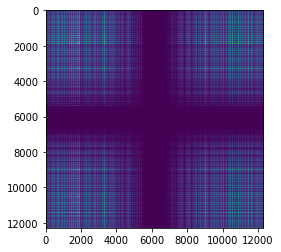

In [26]:
plt.imshow(C)

In [24]:
np.linalg.inv(C)

LinAlgError: Singular matrix